<a href="https://colab.research.google.com/github/cygkichi/bucketbrigade/blob/master/smartmill_ver03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
""" Googleドライブから音声ファイルをダウンロード
"""
from google.colab import drive
drive.mount('/content/drive')
!ls /content/drive/My\ Drive/smartmill

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
dryer_sample		     R20190117204623_last02.wav
I20190118194700_First00.wav  R20190117204803_last01.wav
I20190118215800_First01.wav  R20190117204858_last00.wav
I20190118221500_last.wav


In [2]:
import numpy as np
import scipy.signal
import glob
import os
import scipy.io.wavfile
from scipy.io import wavfile
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
#import IPython.display
#IPython.display.Audio(wavfile)

import librosa
import numpy as np
import scipy
from keras import losses, models, optimizers
from keras.activations import relu, softmax
from keras.callbacks import (EarlyStopping, LearningRateScheduler,
                             ModelCheckpoint, TensorBoard, ReduceLROnPlateau)
from keras.layers import (Convolution1D, Dense, Dropout, GlobalAveragePooling1D, 
                          GlobalMaxPool1D, Input, MaxPool1D, concatenate)
from keras.utils import Sequence, to_categorical

Using TensorFlow backend.


In [0]:
class WaveCollector(object):
    """ Main Preprocessing class.
    """
    def __init__(self):
        self.fs        = 44100
        self.nfile     = 0
        self.labellist = []
        self.filename  = []
        self.data      = []
        self.label     = []

    def read(self, filename, label, length=None):
        rate, data = wavfile.read(filename)
        
        """TODO : サンプリング周波数が異なるときの処理"""
        """TODO : BITが異なるときの処理"""
        data = data / 32768
        isStereo = (lambda data: len(data.shape) == 2)
        if isStereo(data):
            data = data[:,0]

        if length is not None:
            data = data[:length]
            
        self.filename.append(filename)
        self.data.append(data)
        self.label.append(label)
        self.nfile += 1
        
    def data_split(self, test_size=0.4):
        self.labellist = list(set(self.label))
        label_idx = {label:i for i, label in enumerate(self.labellist)}
        X     = np.array(self.data)
        y     = np.array([label_idx[l] for l in self.label])
        fname = np.array(self.filename)
        train_idx = np.ones(self.nfile, dtype=np.bool)
        train_idx[:int(test_size * self.nfile)] = False
        np.random.shuffle(train_idx)
        test_idx = np.invert(train_idx)

        self.X_train     = X[train_idx]
        self.y_train     = y[train_idx]
        self.fname_train = fname[train_idx]
        self.X_test      = X[test_idx]
        self.y_test      = y[test_idx]
        self.fname_test  = fname[test_idx]

In [0]:
from keras.layers import Dense
from keras.models import Sequential
from keras.layers.convolutional import Conv1D, UpSampling1D
from keras.layers import Dense, Activation, Flatten, Dropout, Conv1D
from keras.layers.pooling import MaxPooling1D

def get_1d_conv_model(nclass=2, in_size=400):
    model = Sequential()
    model.add(Conv1D(filters=in_size, kernel_size=20))
    model.add(Activation('relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(300, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(2))
    model.add(Activation('softmax'))
    model.compile(loss='mse',optimizer='sgd',metrics=['accuracy'])


    return model


In [0]:
from scipy import signal
def stft_augument(Xs, ys , N):
    nperseg  = 32768
    noverlap = 15000
    newx = []
    newy = []
    for X,y in  zip(Xs,ys):
        f, t, zxx = np.abs(signal.stft(X,nperseg=nperseg, noverlap=noverlap))
        nf, nt = zxx.shape
        idx    = np.random.randint(nt,size=N)
        ax     = zxx.T[idx][:,:400]
        ay     = np.repeat(y,N)
        newx.append(ax)
        newy.append(ay)

    newx = np.vstack(newx)
    newy = np.vstack(newy)
    return newx, newy

In [0]:
""" RUN ML
"""
filenames = glob.glob('/content/drive/My Drive/smartmill/dryer_sample/*.wav')
filenames.sort()

wc = WaveCollector()
for f in filenames:
    label = f.split('/')[-1].split('_')[0]
    wc.read(f, label)
wc.data_split()

x, y = stft_augument(wc.X_train, wc.y_train, 100)
x = np.log10(x)
y = y.flatten()
y = np.eye(2)[y]

a,b = x.shape
x = x.reshape(a,b,1)

model = get_1d_conv_model()
model.fit(x, y, epochs=500, batch_size=200)


/usr/local/lib/python3.6/dist-packages/scipy/signal/spectral.py:1773: UserWarning: nperseg = 32768 is greater than input length  = 32256, using nperseg = 32256
  .format(nperseg, input_length))
/usr/local/lib/python3.6/dist-packages/scipy/signal/spectral.py:1773: UserWarning: nperseg = 32768 is greater than input length  = 30208, using nperseg = 30208
  .format(nperseg, input_length))
/usr/local/lib/python3.6/dist-packages/scipy/signal/spectral.py:1773: UserWarning: nperseg = 32768 is greater than input length  = 30720, using nperseg = 30720
  .format(nperseg, input_length))
/usr/local/lib/python3.6/dist-packages/scipy/signal/spectral.py:1773: UserWarning: nperseg = 32768 is greater than input length  = 19968, using nperseg = 19968
  .format(nperseg, input_length))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]


Epoch 1/500
3500/3500 [==============================] - 3s 970us/step - loss: 0.2508 - acc: 0.5246
Epoch 2/500
3500/3500 [==============================] - 1s 312us/step - loss: 0.2497 - acc: 0.5429
Epoch 3/500
3500/3500 [==============================] - 1s 312us/step - loss: 0.2495 - acc: 0.5429
Epoch 4/500
3500/3500 [==============================] - 1s 315us/step - loss: 0.2492 - acc: 0.5429
Epoch 5/500
3500/3500 [==============================] - 1s 316us/step - loss: 0.2490 - acc: 0.5429
Epoch 6/500
3500/3500 [==============================] - 1s 310us/step - loss: 0.2489 - acc: 0.5429
Epoch 7/500
3500/3500 [==============================] - 1s 309us/step - loss: 0.2487 - acc: 0.5429
Epoch 8/500
3500/3500 [==============================] - 1s 313us/step - loss: 0.2487 - acc: 0.5429
Epoch 9/500
3500/3500 [==============================] - 1s 311us/step - loss: 0.2486 - acc: 0.5429
Epoch 10/500
3500/3500 [==============================] - 1s 310us/step - loss: 0.2485 - acc: 0.5429

In [9]:
x.shape
y.shape

(3500, 2)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


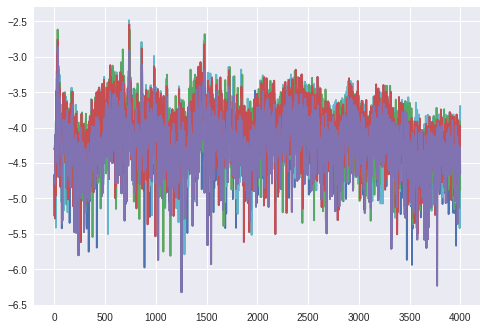

In [0]:
plt.plot(x.reshape(3500,4000)[:10].T)
print(y[:10])


[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


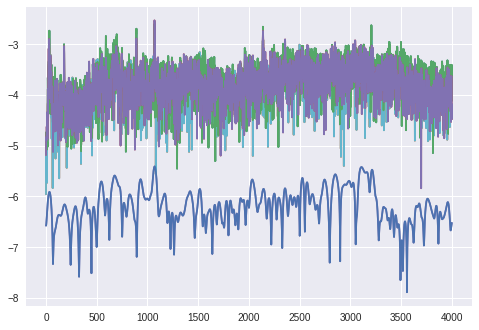

In [0]:
plt.plot(x.reshape(3500,4000)[-10:].T)
print(y[-10:])
